# COVID-19
> "Covid 19 graphs and stats"
- toc: true
- branch: master
- categories: [analysis, python]
- hide: false
- search_exclude: true
- show_tags: true

In [868]:
# hide
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import math
from IPython.display import Markdown as md

sns.set_style('darkgrid')

In [869]:
# hide

# data source
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

df_c = pd.read_csv(url_confirmed)
df_d = pd.read_csv(url_deaths)
df_r = pd.read_csv(url_recovered)

In [870]:
# hide

countries = sorted(['Italy','US','Germany','Spain', 'United Kingdom', 'Poland', 'Israel', 'World'])

countries_without_world = sorted(['Italy','US','Germany','Spain', 'United Kingdom', 'Poland', 'Israel'])

def start(df):
    return df.copy()

def add_world(df):
    world = df.sum(axis=0)
    df.loc[len(df)] = world
    df.loc[len(df)-1,'Country/Region'] = 'World'
    return df

def clean(df):
    df = df.rename(columns={'Country/Region':'country', 'Province/State':'state'})
    # keep uk as uk
    to_drop = df[(df['country']=='United Kingdom') & (df['state']!='United Kingdom')].index
    df = df.drop(index=to_drop)
    return df

def group_and_stack(df):
    date_columns = list(set(df.columns) - set(['Province/State', 'Country','Lat','Long']))
    df_stack = (df.groupby(['country'])[date_columns].sum().stack()
                    .reset_index().rename(columns={'level_1':'date',0:'count'})).copy()
    return df_stack

def convert_date(df):
    df['date'] = pd.to_datetime(df['date'],format='%m/%d/%y')
    return df.sort_values(by=['country','date'])

def add_daily_change(df):
    df['daily_change']=df.groupby(['country'])['count'].diff()
    df['daily_percent_change'] = df['daily_change']/df['count'].shift(1)*100
    df.loc[df[df['daily_percent_change']==np.inf].index,'daily_percent_change']=0
    df = df.fillna(0)
    return df

def limit_countries(df):
    df = df[df['country'].isin(countries)]
    return df

def add_days(df):
    df['days'] = 1
    df['days'] = df.groupby('country')['days'].cumsum()-1
    
    for country in countries:
        more_than_100 = df[(df['count']>=100) & (df['country']==country)]
        if len(more_than_100) > 0:
            dd = more_than_100.iloc[[0]]['days'].values[0]
            df.loc[df[df['country']==country].index, 'days_from_100']=\
                df.loc[df[df['country']==country].index, 'days'] - dd
        else:
            df['days_from_100'] = 0
    return df

In [871]:
# hide

df_confirmed = (df_c.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(limit_countries)
                    .pipe(add_days))

df_recovered = (df_r.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(limit_countries))

df_death = (df_d.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(limit_countries))

In [872]:
# hide_input

md(f"""Last Updated: {df_confirmed['date'].max().date()} <br>
   Data Source: 2019 Novel Coronavirus COVID-19 (2019-nCoV) 
   [Data Repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE """)


Last Updated: 2020-03-21 <br>
   Data Source: 2019 Novel Coronavirus COVID-19 (2019-nCoV) 
   [Data Repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE 

# Cases by country

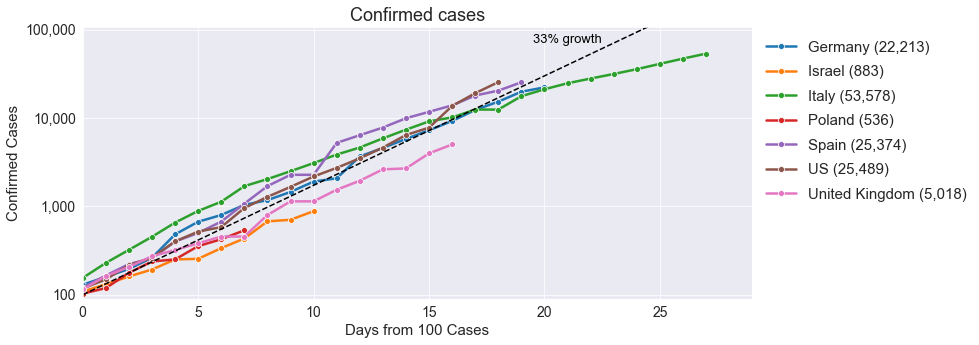

In [873]:
# hide_input

days = (dt.datetime.now().date()-
        df_confirmed[(df_confirmed['country']
                     .isin(countries_without_world)) & (df_confirmed['days_from_100']>0)]['date'].dt.date.min()).days+2
x = np.arange(0,days)
def exp_growth(x):
    return 100*(1.33)**x


max_count = df_confirmed[df_confirmed['country']
                           .isin(countries_without_world)]['count'].max()*2

fig,ax=plt.subplots(figsize=(12,5))

sns.lineplot(data=df_confirmed[df_confirmed['country'].isin(countries_without_world)],
             x='days_from_100', y='count', hue='country', marker='o', linewidth=2.5)

ax.plot(x, exp_growth(x), linestyle='--',color='k')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.annotate(s='33% growth', xy=(days-9.5,exp_growth(days-6)), fontsize=13, color='k')

ax.set(xlim=(0,days), ylim=(90, max_count))
ax.tick_params(axis='both', labelsize=14);
ax.set_ylabel('Confirmed Cases', fontsize=15);
ax.set_xlabel('Days from 100 Cases', fontsize=15)

labels = [f"{country} ({format(df_confirmed[df_confirmed['country']==country].iloc[-1]['count'],',')})" 
          for country in countries_without_world]

plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);
plt.title("Confirmed cases",fontsize=18);

# Worldwide Cases

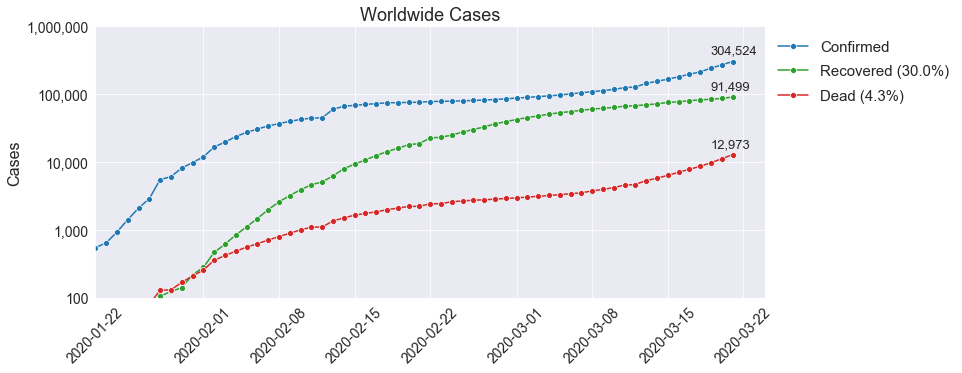

In [874]:
# hide_input

# Worldwide growth

confirmed = df_confirmed[df_confirmed['country']=="World"].iloc[-1]['count']
recovered = df_recovered[df_confirmed['country']=="World"].iloc[-1]['count']
dead = df_death[df_confirmed['country']=="World"].iloc[-1]['count']

last_day = df_confirmed[df_confirmed['country']=="World"].iloc[-1]['date']
first_day = df_confirmed[df_confirmed['country']=="World"].iloc[0]['date']

max_count = df_confirmed[df_confirmed['country']=="World"]['count'].max()*2

fig,ax=plt.subplots(figsize=(12,5))

sns.lineplot(data=df_confirmed[df_confirmed['country'] == "World"],
             x='date', y='count', marker='o',  ax=ax, color=sns.color_palette()[0])

sns.lineplot(data=df_recovered[df_recovered['country'] == "World"],
             x='date', y='count', marker='o', ax=ax, color=sns.color_palette()[2])

sns.lineplot(data=df_death[df_death['country'] == "World"],
             x='date', y='count', marker='o', ax=ax, color=sns.color_palette()[3])

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.tick_params(axis='both', labelsize=14);
ax.tick_params(axis='x', rotation=45);
ax.set_ylabel('Cases', fontsize=16);
ax.set_xlabel('')

ax.set_ylim(100, 10**math.ceil(np.log10(max_count)))
ax.set_xlim(first_day, last_day + dt.timedelta(days=3))

ax.annotate(s=format(confirmed,","), xy=(last_day - dt.timedelta(days=2), confirmed*1.3), 
            fontsize=13)
ax.annotate(s=format(recovered,","), xy=(last_day - dt.timedelta(days=2), recovered*1.3),
            fontsize=13)
ax.annotate(s=format(dead,","), xy=(last_day - dt.timedelta(days=2), dead*1.3),
            fontsize=13)

labels = ["Confirmed",
          f"Recovered ({recovered/confirmed*100:.1f}%)",
          f"Dead ({dead/confirmed*100:.1f}%)"]
plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);

plt.title("Worldwide Cases",fontsize=18);


# Daily Rate of Spread

Percentage change compared to total confirmed cases

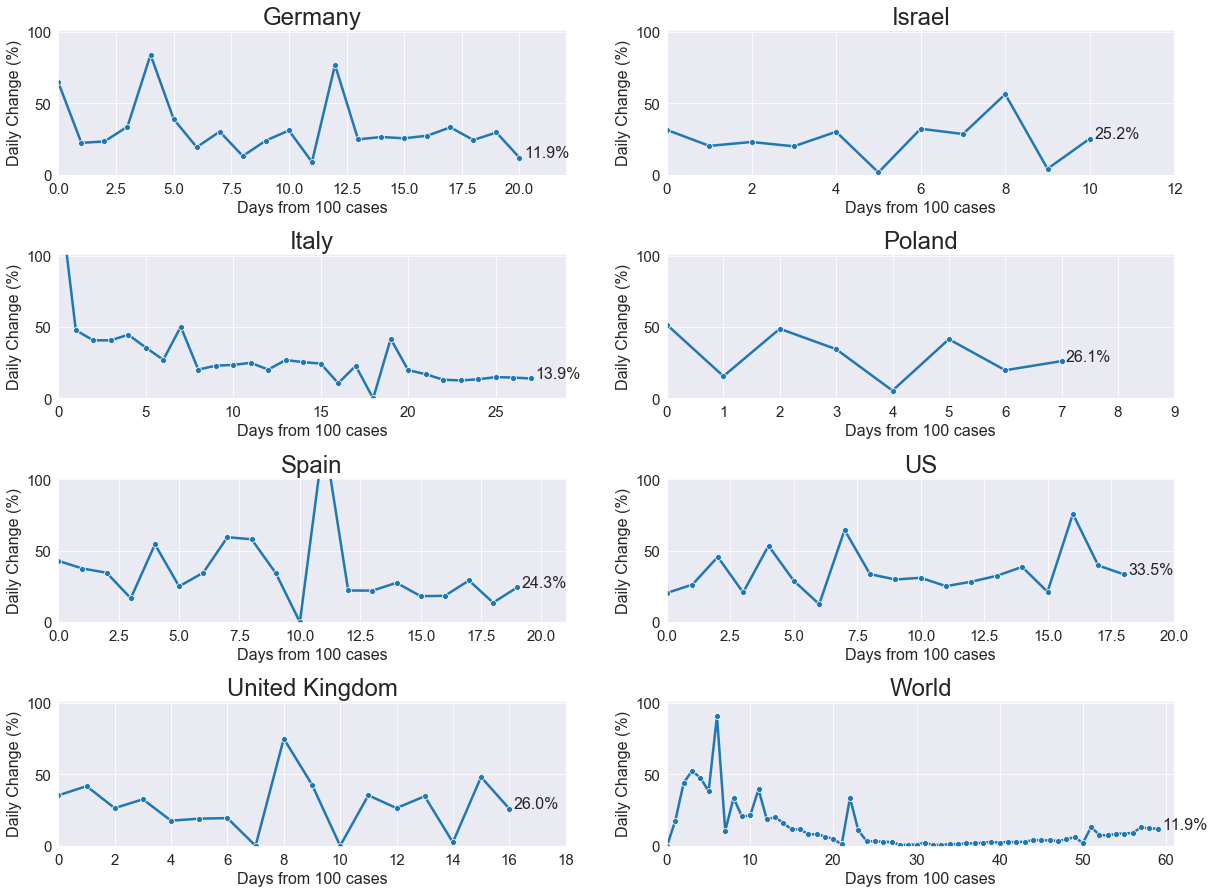

In [867]:
# hide_input

fig,ax=plt.subplots(4,2, figsize=(20,15))

i=0
j=-1
for country in countries:
    j=j+1
    if j==2:
        j = 0
        i += 1
    df_cnt = df_confirmed[df_confirmed['country']==country]
    days = (dt.datetime.now().date()-
        df_cnt[df_cnt['days_from_100']>0]['date'].dt.date.min()).days

    sns.lineplot(data=df_cnt,
                 x='days_from_100', 
                 y='daily_percent_change', marker='o', linewidth=2.5,
                 ax=ax[i][j])
    ax[i][j].set_xlim(0,days+2)
    ax[i][j].set_ylim(0,101)
    ax[i][j].set_xlabel('Days from 100 cases', fontsize=16)
    ax[i][j].set_ylabel('Daily Change (%)', fontsize=16)
    ax[i][j].tick_params(axis='both', labelsize=15)
    ax[i][j].set_title(country, fontsize=24)
    last_change = df_cnt.iloc[-1]['daily_percent_change']
    ax[i][j].annotate(s=f"{last_change:.1f}%", xy=(days*1.01,last_change), fontsize=16)
plt.subplots_adjust(hspace=0.55, wspace=0.2)